### Importing libraries

In [116]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import shutil
import random
import xml.etree.ElementTree as ET
from PIL import Image
import re

import torch
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset

### Defining the path to dataset folders

In [2]:
image_folder = "data\images\Images"
annotation_folder = "data\annotations\Annotation"

In [3]:
# os.listdir(image_folder)

### Cleaning Folder Names
**Removing Numbering**

In [4]:
def clean_class_name(class_name):
    return "-".join(class_name.split("-")[1:])

**Notes:**
This ensures that we retain only the breed names without numerical prefixes.

### Number of Classes & Images per Class

In [5]:
class_counts = {}
for class_name in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        cleaned_name = clean_class_name(class_name) 
        class_counts[cleaned_name] = num_images

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Num Images"])

In [6]:
num_classes = len(df)
print(f"Total number of classes: {num_classes}")

Total number of classes: 120


In [7]:
df

Class  Num Images
0              Chihuahua         152
1       Japanese_spaniel         185
2            Maltese_dog         252
3               Pekinese         149
4               Shih-Tzu         214
..                   ...         ...
115      standard_poodle         159
116     Mexican_hairless         155
117                dingo         156
118                dhole         150
119  African_hunting_dog         169

[120 rows x 2 columns]

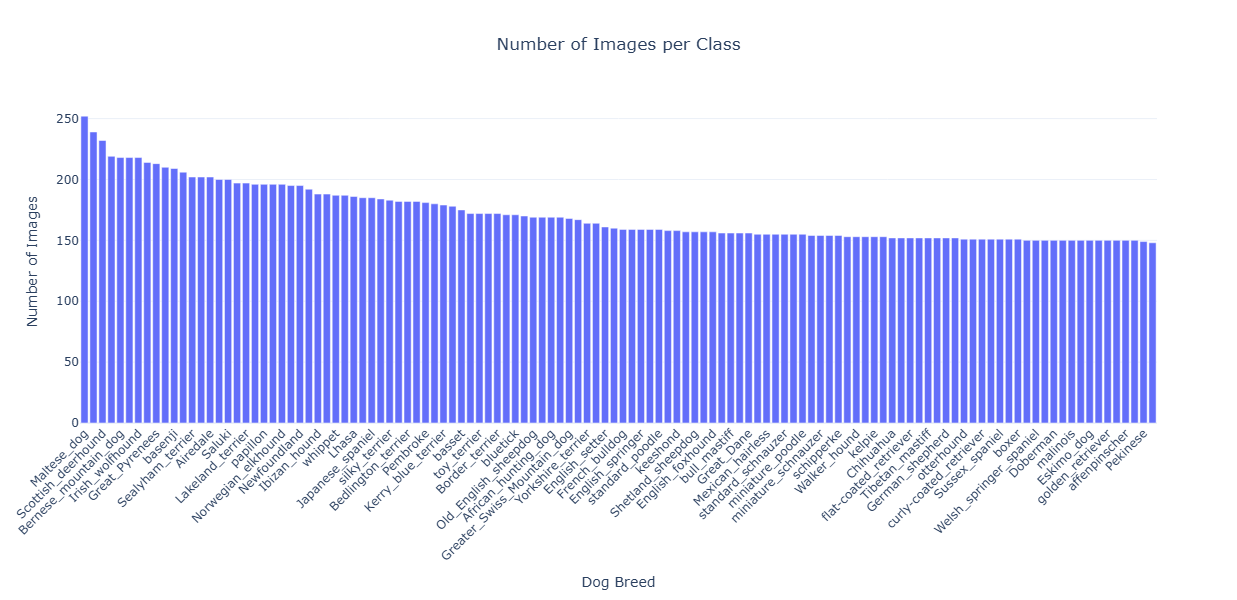

In [8]:
fig = px.bar(df.sort_values("Num Images", ascending=False), 
             x="Class", 
             y="Num Images", 
             title="Number of Images per Class",
             labels={"Class": "Dog Breed", "Num Images": "Number of Images"},
             template="plotly_white") 

fig.update_layout(
    title_x=0.5,
    xaxis_tickangle=-45, 
    yaxis=dict(showgrid=True),
    width=1500, 
    height=600
)

fig.show()

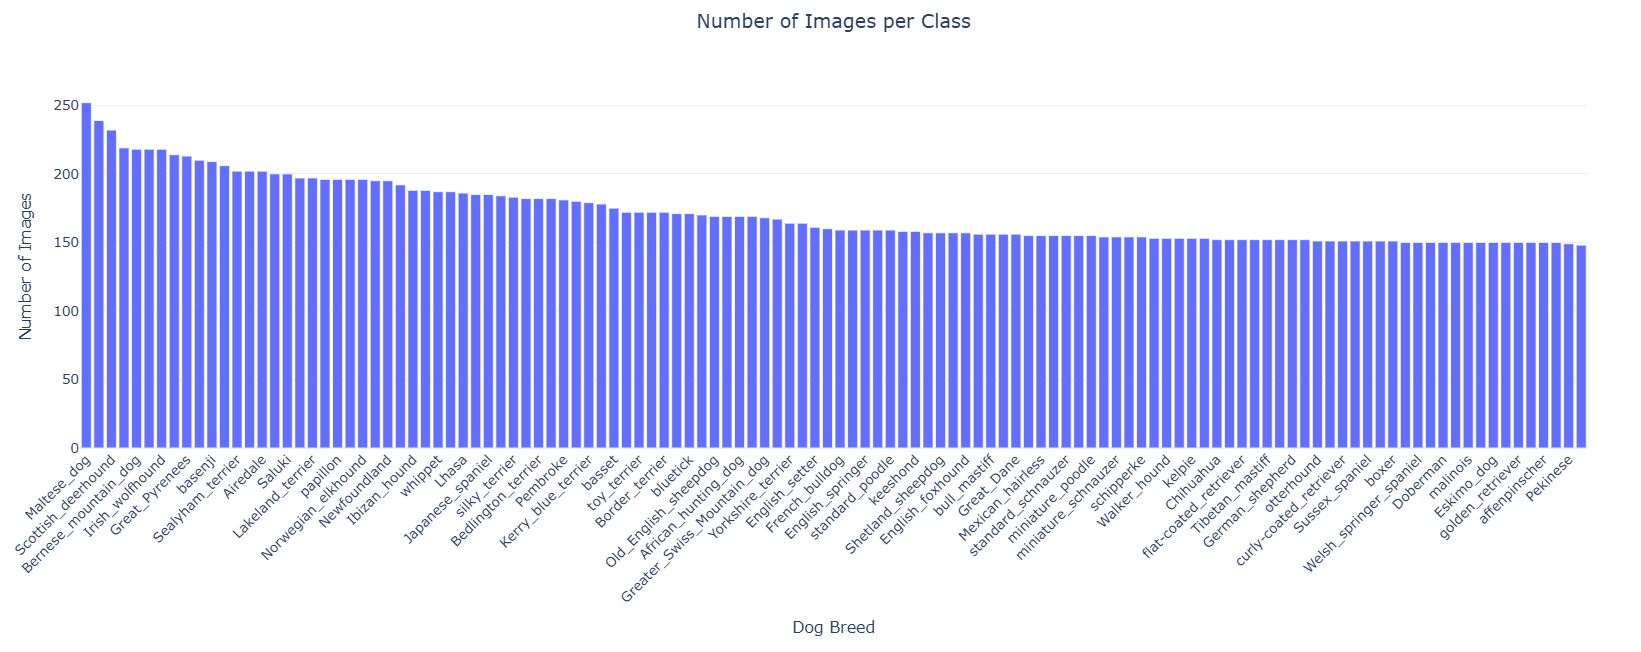

**Notes:**
Counted the total number of classes and visualized the number of images per class using a histogram.
The distribution appears fairly balanced, with images spread almost evenly across classes.

### Splitting the Dataset

**save into folders: test & train & val**

**Notes:** Now, we will split the dataset into three parts: training, testing, and validation.
Each subset will be saved in separate folders within the main directory.

In [9]:
def split_dataset(image_folder, output_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    for class_name in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_name)

        if os.path.isdir(class_path): 
            images = os.listdir(class_path)
            random.shuffle(images)  

            total_images = len(images)
            train_size = int(total_images * train_ratio)
            val_size = int(total_images * val_ratio)

            train_images = images[:train_size]
            val_images = images[train_size:train_size + val_size]
            test_images = images[train_size + val_size:]

            def copy_images(image_list, split_name):
                split_class_path = os.path.join(output_path, split_name, class_name)
                os.makedirs(split_class_path, exist_ok=True)
                
                for img in image_list:
                    src = os.path.join(class_path, img)
                    dst = os.path.join(split_class_path, img)
                    shutil.copy2(src, dst)

            copy_images(train_images, "train")
            copy_images(val_images, "val")
            copy_images(test_images, "test")

    print("finished!")

output_path = "data\images\split_dataset"
split_dataset(image_folder, output_path)

finished!


### The number of images in each dataset split

In [10]:
split_totals = {}

In [11]:
for split in ["train", "val", "test"]:
    split_path = os.path.join(output_path, split)
    total_images = 0
    
    for class_name in os.listdir(split_path):
        class_folder = os.path.join(split_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            total_images += num_images

    split_totals[split] = total_images

In [12]:
for split, count in split_totals.items():
    print(f"Total images in {split}: {count}")

Total images in train: 19744
Total images in val: 3832
Total images in test: 4089


**Notes:** Counted the number of images in each subset (training, validation, and testing).

### Visualization of class images

**Notes:** Now, let's visualize a few images from the training set to assess what preprocessing steps may be necessary.

In [13]:
def show_sample_images(train_folder, num_classes=5, num_images=5):
    class_names = random.sample(os.listdir(train_folder), num_classes)
    
    fig, axes = plt.subplots(num_classes, num_images, figsize=(12, num_classes * 2))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(image_folder, class_name)
        image_names = random.sample(os.listdir(class_path), num_images)

        for j, img_name in enumerate(image_names):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert("RGB") 
            
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()

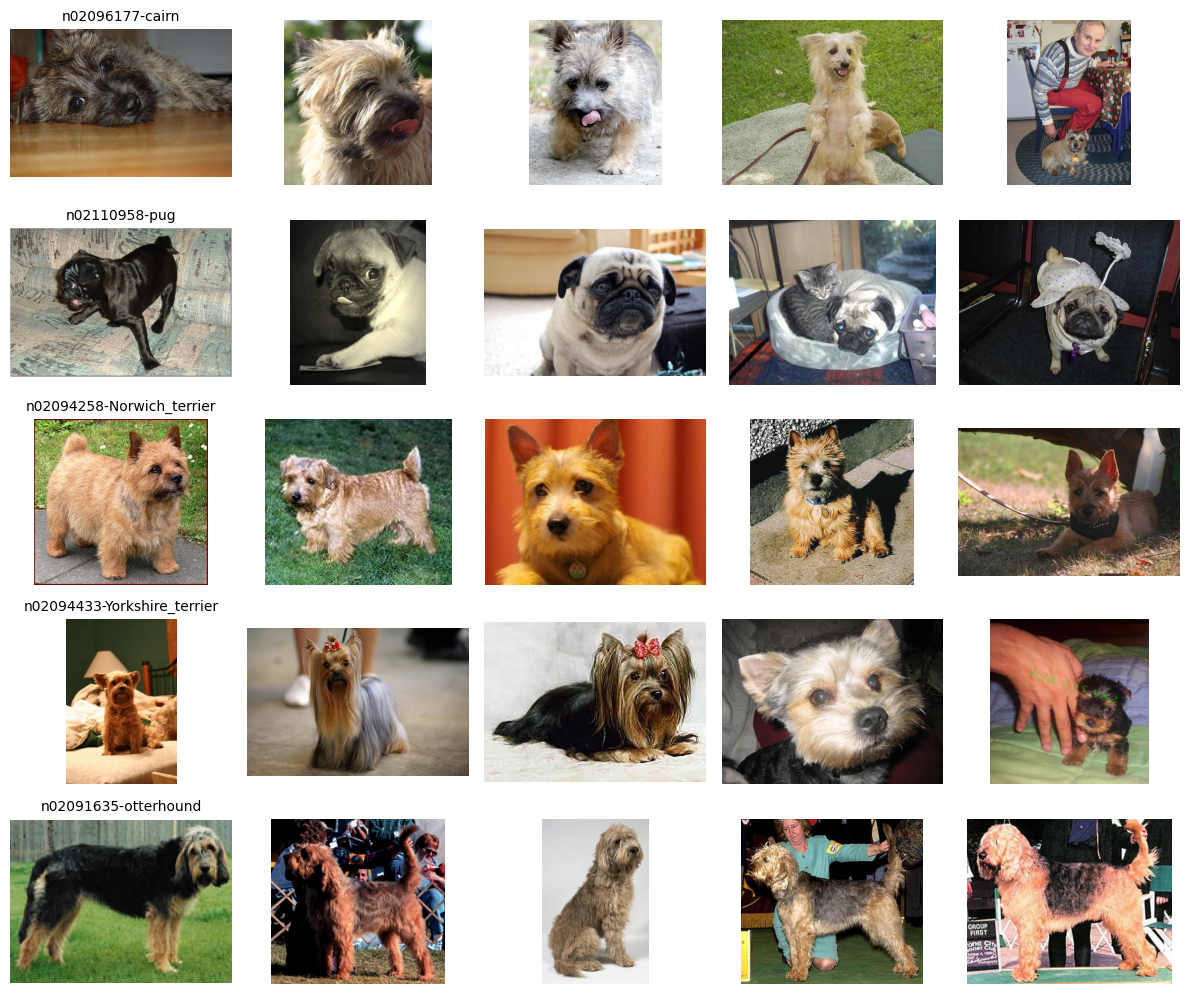

In [14]:
train_folder = "data/images/split_dataset/train"  
show_sample_images(image_folder)

**Notes:** As we can see, the images have different formats.
The first step will be resizing them to a uniform size. I chose the padding method, as it helps preserve the aspect ratio and prevents cropping important parts of the images.

Let's visualize the distribution of image sizes in the dataset.
Plotting a graph will help us understand the overall picture and confirm the need for resizing.

### Distribution of picture sizes

In [15]:
train_folder = "data/images/split_dataset/train"
test_folder = "data/images/split_dataset/test"
val_folder = "data/images/split_dataset/val"

In [17]:
widths = []
heights = []

for class_name in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_name)

    if os.path.isdir(class_path): 
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                with Image.open(img_path) as img:
                    widths.append(img.width)
                    heights.append(img.height)
            except Exception as e:
                print(f"Error with image {img_name}: {e}")

df_sizes = pd.DataFrame({"Width": widths, "Height": heights})


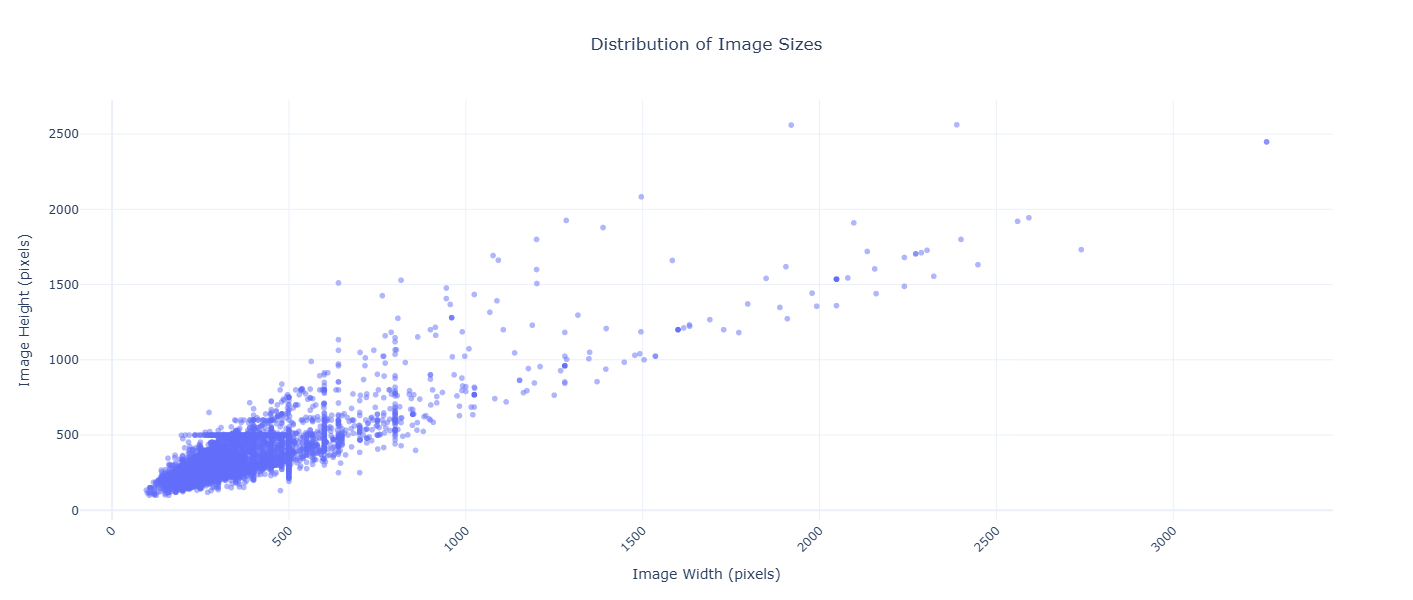

In [20]:
fig = px.scatter(df_sizes, x="Width", y="Height",
                 title="Distribution of Image Sizes",
                 labels={"Width": "Image Width (pixels)", "Height": "Image Height (pixels)"},
                 opacity=0.5,
                 template="plotly_white")

fig.update_layout(
    title_x=0.5,
    xaxis_tickangle=-45, 
    yaxis=dict(showgrid=True),
    width=1200, 
    height=600
)

fig.show()

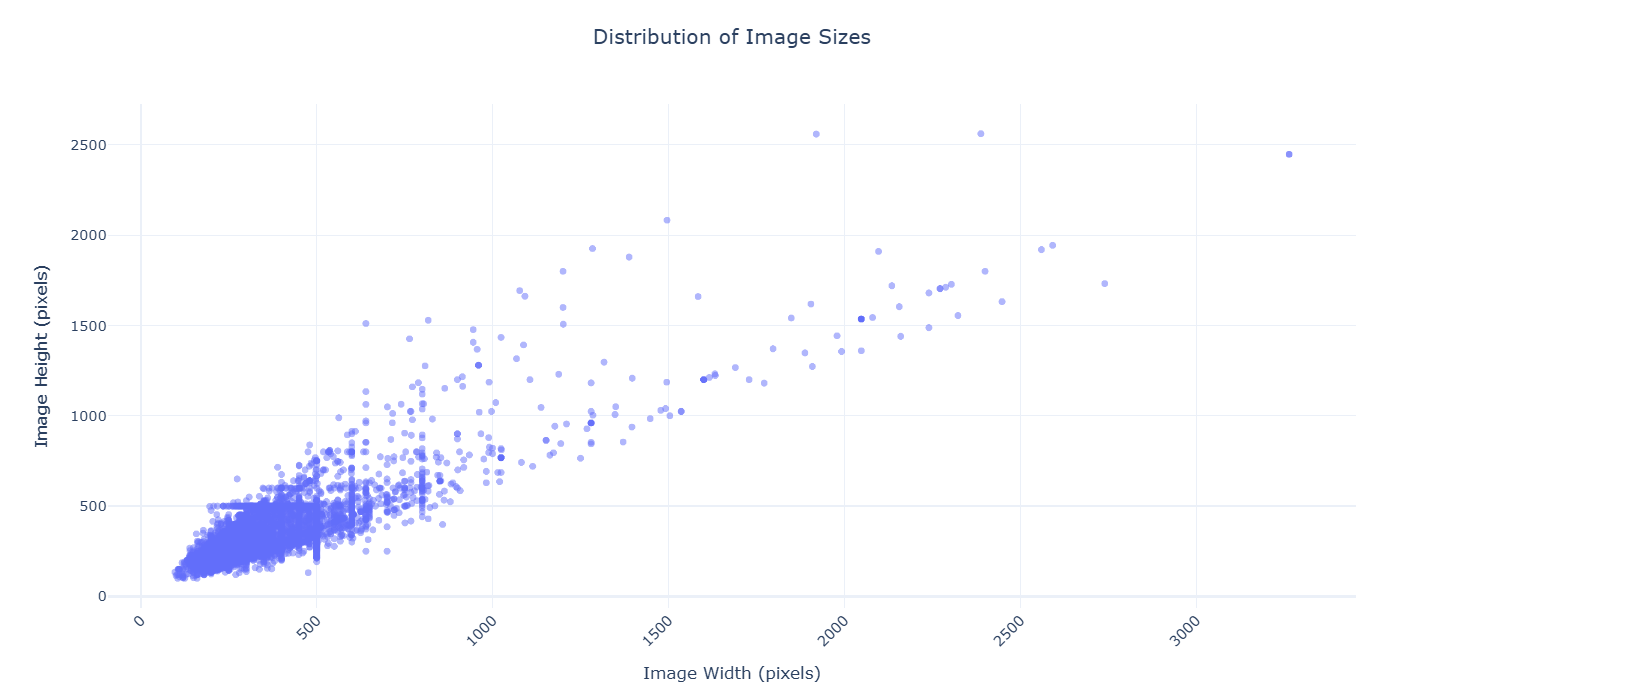

### Resize pictures with padding

Function for resizing all images to (224, 224) while maintaining aspect ratio using padding.

In [59]:
def resize_with_padding(img, target_size=(224, 224), fill=128):
    old_width, old_height = img.size

    if old_width > old_height:
        scale = target_size[0] / old_width
    else:
        scale = target_size[1] / old_height

    new_width = int(old_width * scale)
    new_height = int(old_height * scale)
    img = F.resize(img, (new_height, new_width))  

    # print(f"Original: {old_width}x{old_height}, Scaled: {new_width}x{new_height}")

    pad_x = (target_size[0] - new_width) // 2
    pad_y = (target_size[1] - new_height) // 2

    new_img = Image.new("RGB", target_size, (fill, fill, fill))
    new_img.paste(img, (pad_x, pad_y))

    return new_img

#### Testing the function on a single pug image

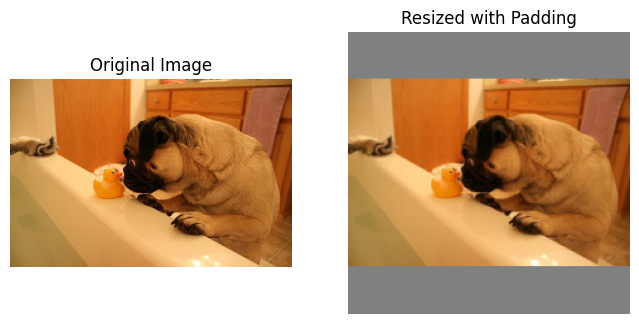

In [60]:
test_image_path = "data/images/split_dataset/train/n02110958-pug/n02110958_7698.jpg"
output_test_path = "data/images/resized_dataset/test_fixed.jpg"

if os.path.exists(test_image_path):
    with Image.open(test_image_path) as img:
        resized_img = resize_with_padding(img, target_size=(224, 224), fill=128)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(resized_img)
        ax[1].set_title("Resized with Padding")
        ax[1].axis("off")

        plt.show()
        resized_img.save(output_test_path)
else:
    print("not found!")

**Notes:** The function works well, so now let's apply it to all images in the dataset and save them in separate folders.

In [48]:
def process_and_save_images(image_folder, output_folder, target_size=(224, 224), fill=128):
    os.makedirs(output_folder, exist_ok=True)

    for class_name in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_name)
        output_class_path = os.path.join(output_folder, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                output_img_path = os.path.join(output_class_path, img_name)

                try:
                    with Image.open(img_path) as img:
                        processed_img = resize_with_padding(img, target_size, fill) 
                        processed_img.save(output_img_path)  
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")

In [53]:
# image_folder = "data/images/split_dataset/val"
# output_folder = "data/images/resized_dataset/val"

# process_and_save_images(image_folder, output_folder, target_size=(224, 224), fill=128)

### Augmentation for training set 

**Notes:** Performing data augmentation will help prevent potential overfitting and increase image diversity.
Let's apply augmentation to enhance the dataset.

In [104]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.95, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(degrees=15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

### Transformation into tensors

**Notes:** Converting images to tensors for efficient processing in PyTorch.
This allows us to feed the images into a deep learning model while maintaining their structure and enabling GPU acceleration.

In [105]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

In [106]:
train_dataset = datasets.ImageFolder(root="data/images/resized_dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="data/images/resized_dataset/val", transform=transform)
test_dataset = datasets.ImageFolder(root="data/images/resized_dataset/test", transform=transform)

In [107]:
print(f"Num of pictures in the train set {len(train_dataset)}")
print(f"Num of pictures in the val set: {len(val_dataset)}")
print(f"Num of pictures in the test set: {len(test_dataset)}")

Num of pictures in the train set 19829
Num of pictures in the val set: 3832
Num of pictures in the test set: 4089


### DataLoaders

**Notes:** Creating data loaders for efficient batch processing and model training.
They help manage memory usage, speed up training, and ensure proper shuffling of data.

In [108]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [109]:
print(f"Num of batch у train_loader: {len(train_loader)}")
print(f"Num of batch у val_loader: {len(val_loader)}")
print(f"Num of batch у test_loader: {len(test_loader)}")

Num of batch у train_loader: 620
Num of batch у val_loader: 120
Num of batch у test_loader: 128


In [117]:
def clean_class_name(class_name):
    return re.sub(r"n\d{8}-", "", class_name)

In [118]:
class_names = [clean_class_name(name) for name in train_dataset.classes]

### Visualization of images after augmentation

**Notes:** This helps verify that the transformations are applied correctly and the dataset remains diverse.

In [119]:
def visualize_augmented_images(dataloader):
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5  
        ax.imshow(img.numpy())
        ax.set_title(class_names[labels[i]]) 
        ax.axis("off")

    plt.show()

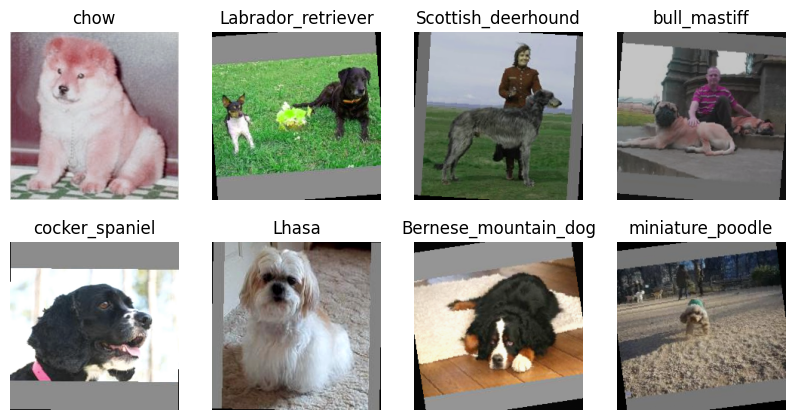

In [120]:
visualize_augmented_images(train_loader)

### More to come next!🐾